<a href="https://colab.research.google.com/github/RMilock/ComplexSpread/blob/Test/MySpread.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Goals:
* Create a regular squared graph and make the SIR dynamics evolve;
* Add nodes as in the Erdoes-Rényi model + SIR dynamic;
* Check at the S/N, I/N, R/N curves and check the epidemic threshold

In [1]:
import random
import networkx as nx
import networkx.generators.lattice as lattice
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import product

# SIR on regular lattice

## Create a squared lattice

In [2]:
def rgraph(N,p):
    G = nx.Graph()

    G.add_node(0,x=0,y=0)                                                                             
    G.add_node(1,x=100,y=0)                                                                             
    G.add_node(2,x=0,y=100)                                                                             
    G.add_node(3,x=100,y=100)
    'adds N nodes'
    G.add_nodes_from(range(4,N))
    
    edges = set() #avoid to put same link twice (unordered)
    for i,j in product(range(4), repeat=2):
      if j==(i+1)%4 or j==(i-1)%4: edges.add((i,j))
    for i,j in product(range(4), range(4,N)):
      if i != j and random.random() <= p: # since we want it to work the p% of times
        edges.add((i,j))
    
    G.add_edges_from(edges)
    #nx.draw(G)
    return G    

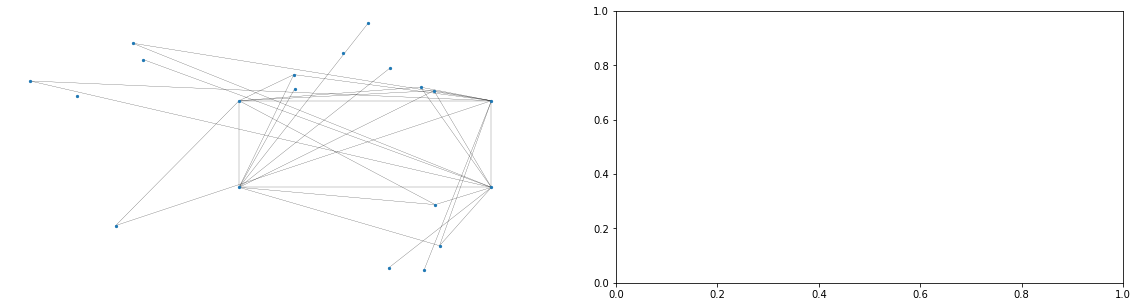

In [16]:
fig, axs = plt.subplots(1,2, figsize=(20,5))

p=0.5

G = nx.Graph()

pos = {0:(0,0),1:(1,0),2:(1,1),3:(0,1)}#dict with two of the positions set
scale=5
for i in range(4,N): pos[i]=(random.random()+1, random.random()+1)
print(pos)

G.add_nodes_from(pos.keys())
for n, coord in pos.items():
   G.nodes[n]['pos'] = coord
edges = set() #avoid to put same link twice (unordered)
for i,j in product(range(4), repeat=2):
  if j==(i+1)%4 or j==(i-1)%4: edges.add((i,j))
for i,j in product(range(4), range(4,N)):
  if i != j and random.random() <= p: # since we want it to work the p% of times
    edges.add((i,j))

G.add_edges_from(edges)

nx.draw(G, ax=axs[0], pos=pos, with_labels=True, font_size=12, node_size=5, width=.3)


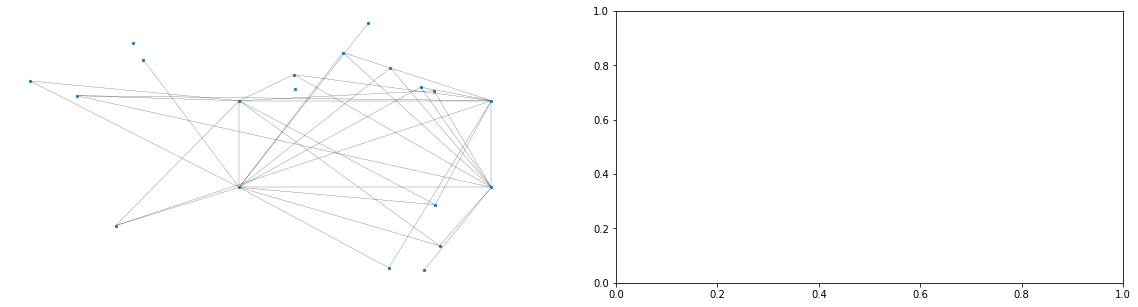

In [17]:
fig, axs = plt.subplots(1,2, figsize=(20,5))


def rgraph(N,p):
    G = nx.Graph()

    pos = {0:(0,0),1:(1,0),2:(1,1),3:(0,1)}#dict with two of the positions set
    for i in range(4,N): pos[i]=(random.random()*(-1)**random.randint(0,10), random.random()+(-1)**random.randint(0,10) )

    G.add_nodes_from(pos.keys())
    for n, coord in pos.items():
      G.nodes[n]['pos'] = coord
    edges = set() #avoid to put same link twice (unordered)
    for i,j in product(range(4), repeat=2):
      if j==(i+1)%4 or j==(i-1)%4: edges.add((i,j))
    for i,j in product(range(4), range(4,N)):
      if i != j and random.random() <= p: # since we want it to work the p% of times
        edges.add((i,j))

    G.add_edges_from(edges)

    return G

G=rgraph(20,0.5)

nx.draw(G, ax=axs[0], pos=pos, with_labels=False, font_size=12, node_size=5, width=.2)




## Make the disease spread

In [ ]:
def sir(G,beta,mu):
    'Number of nodes in the graph'
    N=G.number_of_nodes()
    
    'Creates the labels for all the individuals'
    node_labels = G.nodes()
    
    'Creates an empty list to store currently infected individuals' 
    inf_list = [] 
    
    'Creates an empty list to store the time evolution of the infected and the recovered' 
    prevalence = []
    recovered = []


    'Sets the current and future state to S for all the individuals'
    current_state = ['S' for i in node_labels] 
    future_state = ['S' for i in node_labels]
    
    'Selects the seed of the disease'
    seed = random.choice(range(N)) 

    'Sets the status of the seed to I'
    current_state[seed] = 'I'
    future_state[seed] = 'I'
    
    'Adds the seed to the infected list'
    inf_list.append(seed)
    
   
    'Temporal evolution of the dynamics, runs until there are no infected '
    while(len(inf_list)>0):
        
        'Infection Phase: each infected picks K individuals at random and tries to infect them'        
        for i in inf_list:
            
            'Select the neighbors of the infected node'
            tests = G.neighbors(i) #the only != is here: contact are taken from G.neighbors
            
            for j in tests:

                'If the contact is susceptible tries to infect it'
                if current_state[j] == 'S' and future_state[j] == 'S':
                    
                    if random.random() < beta:
                        
                        'IMPORTANT: the status is checked on the current state but updated in the future state'
                        future_state[j] = 'I'

                    else:
                        
                        future_state[j] = 'S'
                        
        'Recovery Phase: each infected in the current state recovers with probability mu'        
        for i in inf_list:
            
            'Also the recovery takes place in the future state'
            if random.random() < mu:
                
                future_state[i] = 'R'
    
            else:
                 
                future_state[i] = 'I'
        
        'Time update: once infections and recovery ended, we move to the next time-step'
        'The future state becomes the current one'
        current_state = future_state.copy()
       
        'Updates inf_list with the currently infected' 
        inf_list = [i for i, x in enumerate(current_state) if x == 'I']
        rec_list = [i for i, x in enumerate(current_state) if x == 'R']

        
        'Saves the fraction of infected and recovered in the current time-step'
        prevalence.append(len(inf_list)/float(N))
        recovered.append(len(rec_list)/float(N))

        
    return prevalence, recovered

          

In [ ]:
beta = 0.1 # infection probability
mu = 0.05 # recovery probability

# simulate SIR dynamics and obtain prevalence
prevalence, recovered = sir(G, beta, mu)

plt.plot(prevalence)

plt.xlabel('Time', fontsize = 16)
plt.ylabel('I/N', fontsize = 16)

plt.plot(recovered)

plt.xlabel('Time', fontsize = 16)
plt.ylabel('R/N', fontsize = 16)